In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Lecture 25 - Deep Neural Networks Continued

## Objectives

+ Implement image classification network in `PyTorch`.
+ Add L2 regularization.
+ Add convolutional layers.
+ Add hyperparameter tuning.

## References 

+ [Deep Learning with PyTorch: A 60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and in particular:
    - [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) - with which we use the same dataset in this hands-on activity.

## The CIFAR10 dataset

We are going to use the [CIFAR10 dateset](https://www.cs.toronto.edu/~kriz/cifar.html) to demonstrate multiclass classification.
The dataset consists of 60000 32x32 color images in 10 classes (plane, car, bird, cat, deer, dog, frog, horse, ship, and truck), with 6000 images per class.
The dataset can be download direclty from `PyTorch` using the module `torchvision`.

You can think of the original images as 32x32x3 arrays.
The first two dimensions correspond to the pixels.
The third dimension corresponds to the color (red, green, blue).
Of course, we will have to turn them into `PyTorch` tensors.
Also, it is more convenient to scale them to be between $[-1,1]$.
We will achieve this using a transformation.
Don't worry about this now.
We will explain it as we go.

In [57]:
import torch
import torchvision
import torchvision.transforms as transforms

# This is the transformation that we will apply to each image
transform = transforms.Compose(
    [transforms.ToTensor(),   # This turns the picture to a Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # This scales it to [-1, 1]

# Here is how you can download the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# And here is how to download the test dataset:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# These are the class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Now, all these data went in the folder "./data."
Here is what this folder contains:

In [14]:
!ls ./data/

cifar-10-batches-py    cifar-10-python.tar.gz


The file `cifar-10-python.tar.gz` is a compressed file containing everything.
The contents were automatically extracted and put in the folder `cifar-10-batches-py`.
Let's look insider this folder:

In [19]:
!ls -lht data/cifar-10-batches-py

total 363752
-rw-r--r--@ 1 iliasbilionis  staff    88B Jun  4  2009 readme.html
-rw-r--r--@ 1 iliasbilionis  staff   158B Mar 31  2009 batches.meta
-rw-r--r--@ 1 iliasbilionis  staff    30M Mar 31  2009 data_batch_4
-rw-r--r--@ 1 iliasbilionis  staff    30M Mar 31  2009 data_batch_1
-rw-r--r--@ 1 iliasbilionis  staff    30M Mar 31  2009 data_batch_5
-rw-r--r--@ 1 iliasbilionis  staff    30M Mar 31  2009 data_batch_2
-rw-r--r--@ 1 iliasbilionis  staff    30M Mar 31  2009 data_batch_3
-rw-r--r--@ 1 iliasbilionis  staff    30M Mar 31  2009 test_batch


You see several files.
The important ones are `data_batch_1` to `data_batch_5` and `test_batch`.
Each of these contains 10000 images in a binary format.
The format is explained [here](https://www.cs.toronto.edu/~kriz/cifar.html).
We can read them as follows:

In [28]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data = unpickle('data/cifar-10-batches-py/data_batch_1')
# data is a dictionary
# Here are the keys
print(data.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [29]:
# One key has to do with the pictures
# It gives you a numpy array:
print(data[b'data'].shape)

(10000, 3072)


In [30]:
# The first dimension correspond to differnt picture
# The second dimension is
32 * 32 * 3

3072

In [60]:
# So this is the first picture:
img = data[b'data'][0, :].reshape((32, 32, 3), order='F')
# Here is the Red channel:
print(img[:, :, 0])

[[ 59  16  25 ... 208 180 177]
 [ 43   0  16 ... 201 173 168]
 [ 50  18  49 ... 198 186 179]
 ...
 [158 123 118 ... 160 184 216]
 [152 119 120 ...  56  97 151]
 [148 122 109 ...  53  83 123]]


The numbers go from 0 (no red) to 255 (full red).
Here is how to visualize it:

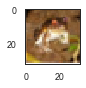

In [61]:
fig, ax = plt.subplots(figsize=(1, 1))
ax.imshow(np.transpose(img, (1, 0, 2)));

This is clearly a frog.
Let's verify this:

In [62]:
classes[data[b'labels'][0]]

'frog'

This is nice. And we could proceed manually like this.
However, `PyTorch` offers some useful functionality.
Let's investigate the `trainset` that was returned by `CIFAR10`:

In [65]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [66]:
# Here are the classes:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [67]:
# Here is the correspondence between classes and discrete labels
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [70]:
# Here are the images from all training batches
print(trainset.data.shape)

(50000, 32, 32, 3)


In [72]:
# Here are the labels
print(trainset.targets[:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


Alright.
Now, let's use `PyTorch` functionality for looping over the training and the test datasets.
We need a [DataLoader](https://pytorch.org/docs/stable/data.html):

In [183]:
# One for the training data:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# One for the test data:
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)


These objects work as follows:

In [80]:
# They help you loop over all the data in a random way (because we had shuffle=True)
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    # Here inputs are of size batch_size x (3 x 32 x 32)
    # Since we had specified, the batch_size to be 4
    # this essentially loads four images per iteration
    if i % 1000 == 0:
        print('Data point:', i, 'input size:', str(inputs.shape))

Data point: 0 input size: torch.Size([4, 3, 32, 32])
Data point: 1000 input size: torch.Size([4, 3, 32, 32])
Data point: 2000 input size: torch.Size([4, 3, 32, 32])
Data point: 3000 input size: torch.Size([4, 3, 32, 32])
Data point: 4000 input size: torch.Size([4, 3, 32, 32])
Data point: 5000 input size: torch.Size([4, 3, 32, 32])
Data point: 6000 input size: torch.Size([4, 3, 32, 32])
Data point: 7000 input size: torch.Size([4, 3, 32, 32])
Data point: 8000 input size: torch.Size([4, 3, 32, 32])
Data point: 9000 input size: torch.Size([4, 3, 32, 32])
Data point: 10000 input size: torch.Size([4, 3, 32, 32])
Data point: 11000 input size: torch.Size([4, 3, 32, 32])
Data point: 12000 input size: torch.Size([4, 3, 32, 32])


When you reach the end of the loop you have visited all the images once.
Notice that `PyTorch` has reshaped the images to 3 x 32 x 32 3D arrays.
This is more convenient for the convolutional layers we are going to use later.
Also, `PyTorch` is using the transformations we gave it to scale the data to array elements to $[-1, 1]$.
Let me show you an example:

In [83]:
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print(inputs[0])
    break

tensor([[[ 0.1608,  0.0196, -0.0431,  ..., -0.9373, -0.8431, -0.3961],
         [-0.1294,  0.0196, -0.1686,  ..., -0.9529, -0.4902, -0.1451],
         [-0.4510, -0.3176, -0.2627,  ..., -0.8667, -0.5137, -0.3255],
         ...,
         [ 0.4980,  0.3725,  0.4510,  ...,  0.3098,  0.3098,  0.3255],
         [ 0.4588,  0.3882,  0.4353,  ...,  0.3412,  0.3490,  0.3647],
         [ 0.4196,  0.4353,  0.4902,  ...,  0.4353,  0.4431,  0.4902]],

        [[-0.1294, -0.2863, -0.3804,  ..., -0.9843, -0.9373, -0.5922],
         [-0.3804, -0.2706, -0.5216,  ..., -0.9843, -0.6235, -0.4431],
         [-0.6627, -0.5765, -0.5765,  ..., -0.9451, -0.6941, -0.6392],
         ...,
         [ 0.1216,  0.0275,  0.1216,  ..., -0.0667, -0.0745, -0.0588],
         [ 0.0824,  0.0196,  0.0667,  ..., -0.0118, -0.0196, -0.0039],
         [ 0.0588,  0.0745,  0.1137,  ...,  0.0980,  0.0824,  0.1216]],

        [[-0.2471, -0.4510, -0.5216,  ..., -0.9059, -0.9216, -0.6627],
         [-0.4902, -0.4118, -0.6078,  ..., -0

## Training a classifier using a dense DNNs

Let's just train a classifer using a dense neural network.
It's not going to work very well, but it is very easy to put together.
We are going to start the network with 3 x 32 x 32 = 3072, followed up with a few dense layers that end at 10 outputs passed through softmax.
However, for reasons of numerical stability, we are not going to end with the softmax layer during training.

In [132]:
import torch.nn as nn

# The classifer - The dimensions of the layers have
# been picked to match those of the convolutional neural network
# that we are going to build later
# For now, just notice that we gradually take the 3072-dimensional input
# down to 10 dimensions (the number of classes we have)
# Also, notice that I do not add the softmax layer at this point
model_dense = nn.Sequential(nn.Linear(3072, 1176), nn.ReLU(),
                            nn.Linear(1176, 400), nn.ReLU(),
                            nn.Linear(400, 120), nn.ReLU(),
                            nn.Linear(120, 84), nn.ReLU(),
                            nn.Linear(84, 10))

# This is our loss function. 
# Read this: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = nn.CrossEntropyLoss()
# The reason we did not add the Softmax layer at the end is because
# the loss function above is doing it internally.
# It expects that you provide "contain raw, unnormalized scores for each class"

In [133]:
# Here is the optimizer
import torch.optim as optim
optimizer = optim.SGD(model_dense.parameters(), lr=0.001, momentum=0.9)

Let's train the network. This is going to take a while...

In [136]:
# How many times do you want to go over the entire dataset?
# Don't pick a very big number because you will overfit
num_epochs = 2

# Here is the main training algorithm
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_dense(inputs.reshape(4, 3 * 32 * 32))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.721
[1,  4000] loss: 1.652
[1,  6000] loss: 1.614
[1,  8000] loss: 1.561
[1, 10000] loss: 1.528
[1, 12000] loss: 1.497
[2,  2000] loss: 1.434
[2,  4000] loss: 1.407
[2,  6000] loss: 1.411
[2,  8000] loss: 1.410
[2, 10000] loss: 1.396
[2, 12000] loss: 1.381
Finished Training


Since training networks takes a while, it's a good idea to save it:

In [137]:
torch.save(model_dense.state_dict(), 'hands-on-25-model-dense.pth')

Here it is as a file:

In [138]:
!ls -lht hands-on-25-model-dense.pth

-rw-r--r--@ 1 iliasbilionis  staff    16M Oct 22 13:24 hands-on-25-model-dense.pth


Now let's make some predictions:

In [139]:
# Get the first four images and their labels
dataiter = iter(testloader)
images, labels = dataiter.next()

In [140]:
print(labels)

tensor([3, 8, 8, 0])


In [141]:
# Make predictions with the net and pass them through 
# softmax to turn them into probabilities
st = nn.Softmax(dim=1)
predictions = st(model_dense(inputs.reshape(4, 3072)))

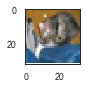

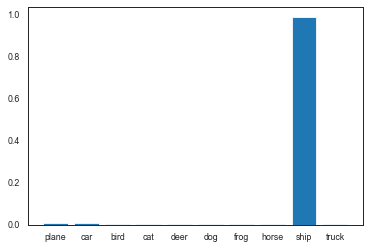

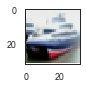

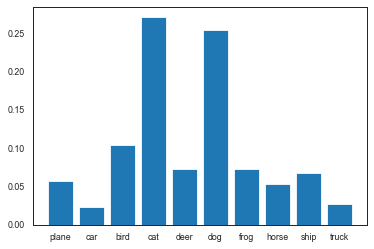

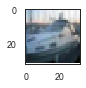

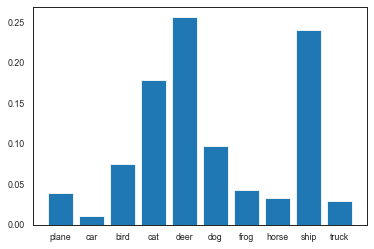

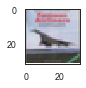

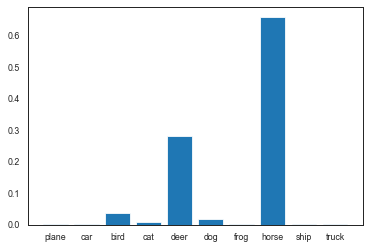

In [142]:
def imshow(img, ax):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

# Plot the pictures and the predictions
for i in range(4):
    fig, ax = plt.subplots(figsize=(1,1))
    imshow(images[i], ax)
    fig2, ax2 = plt.subplots()
    ax2.bar(np.arange(10), predictions[i].detach().numpy())
    ax2.set_xticks(np.arange(10))
    ax2.set_xticklabels(classes)

Now, let's do the same thing with a convolutional neural network.
We are not going to use `nn.Sequential` this time.
Instead, we are going to use `nn.Module` to manually create the network.
The documentation is [here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
You basically need to inherit `nn.Module`, and implement `__init__()` and `forward()`.

In [184]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # A convolutional layer:
        # 3 = input channels (colors),
        # 6 = output channels (features),
        # 5 = kernel size
        self.conv1 = nn.Conv2d(3, 6, 5)
        # A 2 x 2 max pooling layer - we are going to use it two times
        self.pool = nn.MaxPool2d(2, 2)
        # Another convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Some linear layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # This function implements your network output
        # Convolutional layer, followed by relu, followed by max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Same thing
        x = self.pool(F.relu(self.conv2(x)))
        # Flatting the output of the convolutional layers
        x = x.view(-1, 16 * 5 * 5)
        # Go throught the first dense linear layer followed by relu
        x = F.relu(self.fc1(x))
        # Through the second dense layer
        x = F.relu(self.fc2(x))
        # Finish up with a linear transformation
        x = self.fc3(x)
        return x


model_cnn = Net()

Here is a new optimizer:

In [185]:
model_cnn

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [186]:
optimizer = optim.SGD(model_cnn.parameters(), lr=0.1, momentum=0.9,
                      weight_decay=5e-4)

In [ ]:
# How many times do you want to go over the entire dataset?
# Don't pick a very big number because you will overfit
num_epochs = 30

# Here is the main training algorithm
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Save it:

In [168]:
torch.save(model_cnn.state_dict(), 'hands-on-25-model-cnn.pth')

Make some predictions:

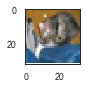

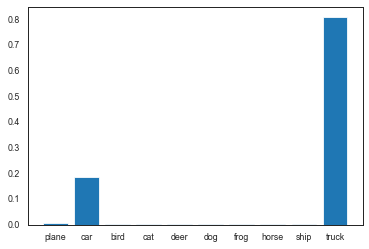

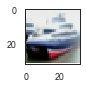

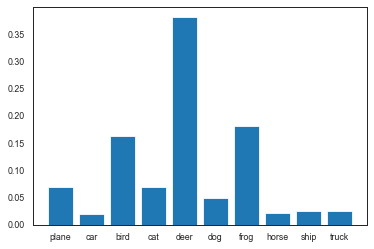

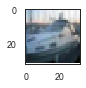

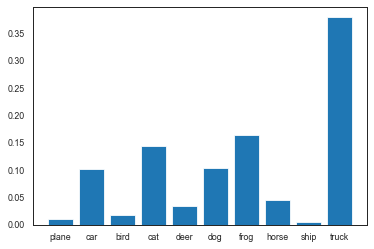

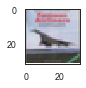

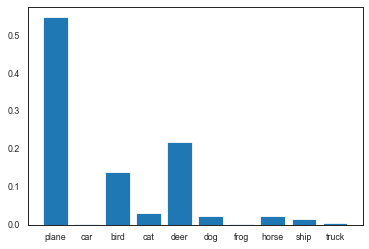

In [175]:
# Make predictions with the net and pass them through 
# softmax to turn them into probabilities
st = nn.Softmax(dim=1)
predictions = st(model_cnn(inputs))
for i in range(4):
    fig, ax = plt.subplots(figsize=(1,1))
    imshow(images[i], ax)
    fig2, ax2 = plt.subplots()
    ax2.bar(np.arange(10), predictions[i].detach().numpy())
    ax2.set_xticks(np.arange(10))
    ax2.set_xticklabels(classes)

4